# Seeking Human Resources
We want to predict how well candidates are fit for certains roles based on their available information:
* EDA
* Modelling
    * Rank canditates based on some roles key words
    * Re-rank candidates when we change the roles key words

## EDA

### LOAD DATA

In [59]:
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_lg")

In [5]:
df=pd.read_csv("potential-talents.csv")
df=df.set_index('id')
df.head()

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


In [11]:
#check data duplicates
print(df.duplicated().sum())

51


In [15]:
#remove duplicates
df.drop_duplicates(inplace=True)
df.shape

(53, 4)

In [16]:
#dropping fit col
df.drop('fit', axis=1,inplace=True)
df.shape

(53, 3)

About the data:
* data consist of 3 columns: job-title-location-connection
* job-title gives the available information of a paticular job

In [24]:
df.job_title.value_counts()

Aspiring Human Resources Professional                                                                                    2
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 1
Lead Official at Western Illinois University                                                                             1
Senior Human Resources Business Partner at Heil Environmental                                                            1
Aspiring Human Resources Professional | An energetic and Team-Focused Leader                                             1
HR Manager at Endemol Shine North America                                                                                1
Human Resources professional for the world leader in GIS software                                                        1
RRP Brand Portfolio Executive at JTI (Japan Tobacco International)                                                       1
Information Syst

Text preprocessing

In [26]:
#import spacy and load the language model downloaded

import spacy
nlp = spacy.load("en_core_web_lg")

In [47]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation with lower case

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_digit:
            continue
        filtered_tokens.append(token.lemma_.lower())
    return ' '.join(filtered_tokens)

In [49]:
#create a new column "preprocessed_text" which store the clean form of given text [use apply and lambda function]

df['preprocessed_job_title'] = df['job_title'].apply(lambda text: preprocess(text))
df['preprocessed_location'] = df['location'].apply(lambda text: preprocess(text))
df.head()

,job_title,location,connection,preprocessed_job_title,preprocessed_location
id,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,c.t. bauer college business graduate magna cum...,houston texas
2,Native English Teacher at EPIK (English Progra...,canada,500+,native english teacher epik english program korea,canada
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resources professional,raleigh durham north carolina area
4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,denton texas
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,i̇zmir türkiye


In [53]:
#replace abreviations and uncorrect words by there real texts
df.replace({'preprocessed_job_title' : { 'chro' : 'chief human resources officer', 'svp' : 'senior vice president'
        ,'gphr' : 'global professional in human resources','hris' : 'human resources management system'
        , 'csr' : 'corporate social responsibility', 'sphr' : 'strategic and policy-making certification'
        , 'hr' : 'human resources'}}, regex=True, inplace=True)

df.replace({'preprocessed_location' : { 'kanada' : 'canada', 'türkiye':'turkey', 'amerika birleşik devletleri' : 'united states america'}}, regex=True, inplace=True)

In [54]:
df.head()

,job_title,location,connection,preprocessed_job_title,preprocessed_location
id,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,c.t. bauer college business graduate magna cum...,houston texas
2,Native English Teacher at EPIK (English Progra...,canada,500+,native english teacher epik english program korea,canada
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resources professional,raleigh durham north carolina area
4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,denton texas
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,i̇zmir turkey


In [63]:
#Second utility function to preprocess words out of vocabulary
def preprocess1(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.is_digit or token.is_oov:
            continue
        filtered_tokens.append(token.lemma_.lower())
    return ' '.join(filtered_tokens)
df['preprocessed_job_title'] = df['preprocessed_job_title'].apply(lambda text: preprocess1(text))
df['preprocessed_location'] = df['preprocessed_location'].apply(lambda text: preprocess1(text))
df.head()

,job_title,location,connection,preprocessed_job_title,preprocessed_location
id,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,bauer college business graduate magna cum laud...,houston texas
2,Native English Teacher at EPIK (English Progra...,canada,500+,native english teacher english program korea,canada
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,raleigh durham north carolina area
4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,denton texas
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member university,


In [64]:
words_counts = Counter()
for i in df.preprocessed_job_title:
    for word in i.split(" "):
        words_counts[word] += 1

print('There are', len(words_counts) ,'words in the job title column')
words_counts.most_common()

There are 153 words in the job title column


[('human', 34),
 ('resource', 33),
 ('aspire', 13),
 ('professional', 10),
 ('seek', 10),
 ('|', 10),
 ('manager', 7),
 ('university', 6),
 ('student', 6),
 ('business', 5),
 ('generalist', 5),
 ('specialist', 4),
 ('position', 4),
 ('management', 4),
 ('opportunity', 3),
 ('director', 3),
 ('major', 3),
 ('college', 2),
 ('english', 2),
 ('coordinator', 2),
 ('hr', 2),
 ('senior', 2),
 ('internship', 2),
 ('retail', 2),
 ('north', 2),
 ('america', 2),
 ('information', 2),
 ('system', 2),
 ('leader', 2),
 ('bauer', 1),
 ('graduate', 1),
 ('magna', 1),
 ('cum', 1),
 ('laude', 1),
 ('native', 1),
 ('teacher', 1),
 ('program', 1),
 ('korea', 1),
 ('people', 1),
 ('development', 1),
 ('ryan', 1),
 ('advisory', 1),
 ('board', 1),
 ('member', 1),
 ('chapman', 1),
 ('svp', 1),
 ('marketing', 1),
 ('communication', 1),
 ('csr', 1),
 ('officer', 1),
 ('houston', 1),
 ('woodlands', 1),
 ('energy', 1),
 ('intercontinental', 1),
 ('atlanta', 1),
 ('experience', 1),
 ('staff', 1),
 ('recruit', 1),


The 5 most common word are **human**, **resources**,  **aspire**,  **professional** and **seek**

## Modeling

### Applying ranking with tfidf and bert transformation

1. Applying tfidf ranking

In [56]:
df1=df.copy()

In [75]:
def rank_candidates_tfidf(keyword,df,feature_name):
    #store cleaned rows into a list
    corpus=df[feature_name].tolist()
    #create an instance of tfidfVectorizer
    tfvectoriser = TfidfVectorizer()
    #Append the cleaned keyword to th corpus list 
    corpus.append(keyword)
    #fit the Tfidf vectorizer on the cleaned data
    key_tf=tfvectoriser.fit_transform(corpus)
    #create a dataframe that contains tfidf values of each token for each row in th data
    key_df=pd.DataFrame(key_tf.toarray(), columns=tfvectoriser.get_feature_names())
    shape=key_df.shape
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(key_tf.toarray()[:shape[0]-1], key_tf.toarray()[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_tfidf']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_tfidf',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus.pop()
    return final_df

 * Test the rank_candidate function

In [87]:
# pip intall -u sentence-tranformers

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import warnings
warnings.filterwarnings("ignore")
from sentence_transformers import SentenceTransformer
# import nltk
# import re
# import string
# import gensim

In [81]:
keyword='aspire human resources'
df1=rank_candidates_tfidf(keyword,df1,"preprocessed_job_title")

In [82]:
#number of ranked candidates based on the keyword
print('There are',df1[df1['fit_tfidf']!=0].shape[0],'ranked candidates for the job',keyword)

There are 35 ranked candidates for the job aspire human resources


In [83]:
#Explore the new column 
df1.head(10)

,job_title,location,connection,preprocessed_job_title,preprocessed_location,fit_tfidf
id,,,,,,
97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspire human resources professional,kokomo indiana area,0.769180
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resources professional,raleigh durham north carolina area,0.769180
6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspire human resources specialist,greater new york city area,0.678790
73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspire human resources manager seek internship...,houston texas area,0.606442
27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,aspire human resources management student seek...,houston texas area,0.441125
66,Experienced Retail Manager and aspiring Human ...,"Austin, Texas Area",57,experience retail manager aspire human resourc...,austin texas area,0.408434
74,Human Resources Professional,Greater Boston Area,16,human resources professional,greater boston area,0.379428
100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,aspire human resources manager | graduating | ...,cape girardeau missouri,0.366335
79,Liberal Arts Major. Aspiring Human Resources A...,"Baton Rouge, Louisiana Area",7,liberal arts major aspire human resources analyst,baton rouge louisiana area,0.353795


2. Applying bert

In [89]:
#Load the pretrained model 
bert = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [90]:
def rank_candidates_bert(keyword,df,feature_name):
    #load bert model 
    bert = SentenceTransformer('all-MiniLM-L6-v2')
    #store cleaned rows into a list
    corpus=df[feature_name].tolist()
    #Append the cleaned keyword to th corpus list 
    corpus.append(keyword)
    #encode our sentences
    sentence_embeddings = bert.encode(corpus)
    print("the shape of our encoded sentences is",sentence_embeddings.shape)
    shape=sentence_embeddings.shape
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(sentence_embeddings[:shape[0]-1], sentence_embeddings[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_bert']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_bert',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus.pop()
    return final_df

In [91]:
keyword='aspire human resources'
df1=rank_candidates_bert(keyword,df1,"preprocessed_job_title")

#number of ranked candidates based on the keyword
print('There are',df1[df1['fit_bert']!=0].shape[0],'ranked candidates for the job',keyword)

the shape of our encoded sentences is (54, 384)
There are 53 ranked candidates for the job aspire human resources


In [92]:
#Explore the new column 
df1.head(10)

,job_title,location,connection,preprocessed_job_title,preprocessed_location,fit_tfidf,fit_bert
id,,,,,,,
97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspire human resources professional,kokomo indiana area,0.769180,0.928787
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resources professional,raleigh durham north carolina area,0.769180,0.928787
6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspire human resources specialist,greater new york city area,0.678790,0.916763
100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,aspire human resources manager | graduating | ...,cape girardeau missouri,0.366335,0.750043
82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspire human resources professional | energeti...,austin texas area,0.335222,0.743191
74,Human Resources Professional,Greater Boston Area,16,human resources professional,greater boston area,0.379428,0.718712
66,Experienced Retail Manager and aspiring Human ...,"Austin, Texas Area",57,experience retail manager aspire human resourc...,austin texas area,0.408434,0.708162
73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspire human resources manager seek internship...,houston texas area,0.606442,0.707531
79,Liberal Arts Major. Aspiring Human Resources A...,"Baton Rouge, Louisiana Area",7,liberal arts major aspire human resources analyst,baton rouge louisiana area,0.353795,0.695704


### Applying re-ranking with TF-IDF transformation

In [95]:
#import packages to build neural network and look at how we did
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu


import matplotlib.pyplot as plt

2022-11-29 16:47:43.691070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-29 16:47:43.692233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-29 16:47:43.692259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [96]:
#Implement RankNet 
class RankNet(Model):
    def __init__(self):
        super().__init__()
        #layers for the neural network
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dropout(0.2), layers.Dense(16, activation=leaky_relu),layers.Dropout(0.2),layers.Dense(16, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    #Implementing ranknet by passing both inputs through the same forward feed network, subtracting, and passing to a sigmoid activation function
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    #Create a separate predict method to get a prediction for the fit from a single input
    def predict(self,_input):
        x=_input
        _dense=self.dense[0](x)
        for dense in self.dense[1:]:
            _dense_=dense(_dense)
        _o=self.o(_dense)
        output=layers.Activation('sigmoid')(_o)
        return output

In [135]:
#X=df1.drop(columns=["job_title", "location","fit_bert"])
X=df1.drop(columns=["job_title", "location"])
X=X.reset_index()
X

,id,connection,preprocessed_job_title,preprocessed_location,fit_tfidf,fit_bert
0,97,71,aspire human resources professional,kokomo indiana area,0.769180,0.928787
1,3,44,aspire human resources professional,raleigh durham north carolina area,0.769180,0.928787
2,6,1,aspire human resources specialist,greater new york city area,0.678790,0.916763
3,100,103,aspire human resources manager | graduating | ...,cape girardeau missouri,0.366335,0.750043
4,82,174,aspire human resources professional | energeti...,austin texas area,0.335222,0.743191
5,74,16,human resources professional,greater boston area,0.379428,0.718712
6,66,57,experience retail manager aspire human resourc...,austin texas area,0.408434,0.708162
7,73,7,aspire human resources manager seek internship...,houston texas area,0.606442,0.707531
8,79,7,liberal arts major aspire human resources analyst,baton rouge louisiana area,0.353795,0.695704
9,99,48,seek human resources position,las vegas nevada area,0.254405,0.661867


In [110]:
import random

In [111]:
#Set seed for reproducibility
random.seed(123)  
#Take two random samples of the data to feed into RankNet neural network
random_row_1 = X.sample(n = 5000, replace = True)
random_row_2 = X.sample(n = 5000, replace = True)
#Create an instance of RankNet and compile
ranknet=RankNet()
ranknet.compile(optimizer='adam',loss='binary_crossentropy',metrics="accuracy")

In [120]:
tfvectoriser = TfidfVectorizer()
tfvectoriser.fit_transform(X.preprocessed_job_title)

In [121]:
def rank(starred=[]):
    #Create a new column for starred scores, that default to the score we have already
    random_row_1["starred_score"]=random_row_1.fit_tfidf
    random_row_2["starred_score"]=random_row_2.fit_tfidf
    for id in starred:
        random_row_1.loc[random_row_1['id']==id,'starred_score']=1
        random_row_2.loc[random_row_2['id']==id,'starred_score']=1
    #Vectorize the job title for the inputs
    doc1=tfvectoriser.transform(random_row_1["preprocessed_job_title"])
    doc2=tfvectoriser.transform(random_row_2["preprocessed_job_title"])
    #Ground truth for ranknet: output is 1 if first entry has higher value, 0 if second entry is higher, 0.5 if tied
    y=[]
    for i in range(len(random_row_1)):
        y_1=random_row_1.iloc[i]['starred_score']
        y_2=random_row_2.iloc[i]['starred_score']
        if y_1>y_2:
            y.append(1)
        elif y_1<y_2:
            y.append(0)
        else:
            y.append(0.5)
    y=np.array(y)
   
    #Train the neural network and return the prediction
    history=ranknet.fit([doc1.toarray(),doc2.toarray()],y,validation_split=0.2,epochs=500,verbose=0)
    fit=ranknet.predict(tfvectoriser.transform(X.preprocessed_job_title).toarray())
    df=X.copy()
    df["fit"]=fit
    return df,history

In [122]:
X_fit_1,history=rank(X)

In [123]:
X_fit_1.sort_values("fit",ascending=False)

,id,connection,preprocessed_job_title,preprocessed_location,fit_tfidf,fit_bert,fit
48,95,57,student westfield state university,bridgewater massachusetts,0.000000,0.174335,0.995147
47,87,40,bachelor science biology victoria university w...,baltimore maryland,0.000000,0.190097,0.994493
38,86,4,information systems specialist programmer love...,gaithersburg maryland,0.000000,0.307937,0.994323
36,80,52,junior mes engineer| information systems,myrtle beach south carolina area,0.000000,0.345305,0.994038
50,93,9,admissions representative community medical ce...,long beach california,0.000000,0.145111,0.992435
52,103,500+,set success,greater los angeles area,0.000000,0.031094,0.992394
46,96,19,student indiana university kokomo business man...,lafayette indiana,0.000000,0.190871,0.990733
40,11,2,student chapman university,lake forest california,0.000000,0.282739,0.990298
45,98,4,student,houston texas area,0.000000,0.191936,0.990200
43,5,500+,advisory board member celal bayar university,i̇zmir turkey,0.000000,0.208498,0.989101


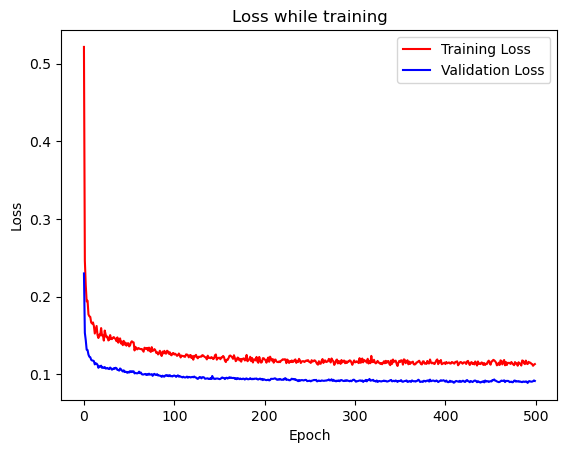

In [124]:
plt.plot(history.history["loss"],color="r")
plt.plot(history.history["val_loss"],color="b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])
plt.title("Loss while training")
plt.show()

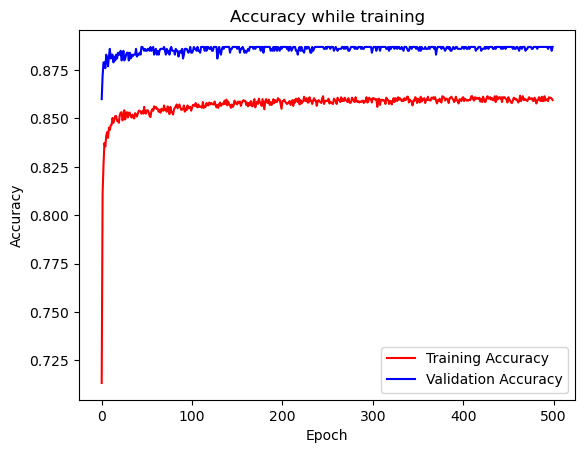

In [125]:
plt.plot(history.history["accuracy"],color="r")
plt.plot(history.history["val_accuracy"],color="b")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.title("Accuracy while training")
plt.show()